# Thesis data generation and analysis
---

## Setup

### Imports, variables and plotting setup

In [404]:
import os
import numpy as np
import string
import random

import seaborn as sns; sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline


# import configuration variable with path
# to the Golang code of the experiment
from config import EXPERIMENT_PATH

# build Golang program
os.system("go build -o " + EXPERIMENT_PATH + "/thesis " + EXPERIMENT_PATH + "/*.go")


# plotting config
plt.style.use('seaborn-talk')
sns.set_style("white")
sns.set_context("paper", font_scale=1.5)

np.random.seed(2424)

### Utility functions

In [405]:
# run experiment with given params
def runExperiment(name, algo="mt", i=10, op="build"):
    os.system(EXPERIMENT_PATH + "/thesis " + "-algo=" + algo +  " -op=" + op + " -name=" + name + " -iter=" + str(i))
    
# clean source and results folders
def cleanupSource():
    os.system("rm " + EXPERIMENT_PATH + "/source/*.txt")

def cleanupResults():
    os.system("rm " + EXPERIMENT_PATH + "/results/*.txt")

In [406]:
# generate n transactions of uniformly distributed length
def genUniTransactions(n, name):
    # generate i uniformly randomly distributed integers n
    # between 900 and 1100. the block length is n*8 bytes
    lengths = np.rint(np.random.uniform(900, 1100, n))
    
    # the function gen_string is vectorized, ready to 
    # process arrays 
    vfunc = np.vectorize(random_string)
    
    # generates strings of given lengths
    samples = vfunc(lengths.astype(int))
    
    with open(EXPERIMENT_PATH + '/source/' + name, 'w') as output:
        for sample in samples:
            output.write(sample + '\n')

# generate random string of specified length
def random_string(length):
    return ''.join(random.choice(string.ascii_letters) for m in range(length))

In [407]:
def computeStats(trials):
    # compute means and standard deviations
    means = np.mean(trials[1:,:], axis=1)
    stds = np.std(trials[1:,:], axis=1)
    
    return means, stds

---

## Experiment

### Uniformly random distributed transactions

In [408]:
def genUniformData(rnge):
    for i in range(rnge[0], rnge[1], rnge[2]):
        SAMPLE = str(i) + '_uniform_samples.txt'

        # generate data
        genUniTransactions(i, SAMPLE)

In [409]:
def randUniformExperiment(algo, trials, rnge):
    for i in range(rnge[0], rnge[1], rnge[2]):
        SAMPLE = str(i) + '_uniform_samples.txt'

        # run exeperiment
        runExperiment(SAMPLE, i=trials, algo=algo)

In [430]:
def getResults(algo, trials, rnge):
    RES_PATH = '/results/result_' + algo + '_'
    NUM_TRIALS = trials

    build_t = np.arange(NUM_TRIALS)
    build_m = np.arange(NUM_TRIALS)
    veri_t = np.arange(NUM_TRIALS)
    veri_m = np.arange(NUM_TRIALS)

    for i in range(rnge[0], rnge[1], rnge[2]):
        SAMPLE = str(i) + '_uniform_samples.txt'

        # load data in-memory for analysis
        result = np.loadtxt(EXPERIMENT_PATH + RES_PATH + SAMPLE, dtype='int', delimiter=', ')
        build_t = np.vstack([build_t, result[:,0]])
        build_m = np.vstack([build_m, result[:,1]])
        veri_t = np.vstack([veri_t, result[:,2]])
        veri_m = np.vstack([veri_m, result[:,3]])
    

    return build_t, build_m, veri_t, veri_m

Done!


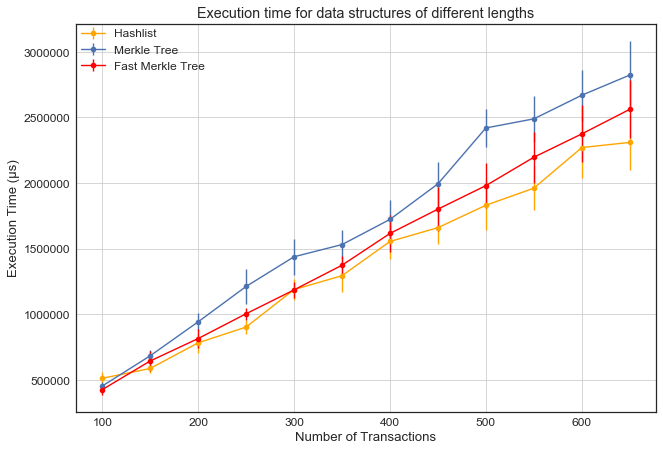

In [437]:
RANGE = 100, 700, 50
TRIALS = 30


# -- START EXPERIMENT -- #

#cleanupResults()
#genUniformData(RANGE)

randUniformExperiment('hl', TRIALS, RANGE)
hl_build_t, hl_build_m, hl_veri_t, hl_veri_m = getResults('hl', TRIALS, RANGE)
hl_build_t_means, hl_build_t_stds = computeStats(hl_build_t)
hl_build_m_means, hl_build_m_stds = computeStats(hl_build_m)
hl_veri_t_means, hl_veri_t_stds = computeStats(hl_veri_t)
hl_veri_m_means, hl_veri_m_stds = computeStats(hl_veri_m)


randUniformExperiment('mt', TRIALS, RANGE)
mt_build_t, mt_build_m, mt_veri_t, mt_veri_m = getResults('mt', TRIALS, RANGE)
mt_build_t_means, mt_build_t_stds = computeStats(mt_build_t)
mt_build_m_means, mt_build_m_stds = computeStats(mt_build_m)
mt_veri_t_means, mt_veri_t_stds = computeStats(mt_veri_t)
mt_veri_m_means, mt_veri_m_stds = computeStats(mt_veri_m)

randUniformExperiment('fmt', TRIALS, RANGE)
fmt_build_t, fmt_build_m, fmt_veri_t, fmt_veri_m = getResults('fmt', TRIALS, RANGE)
fmt_build_t_means, fmt_build_t_stds = computeStats(fmt_build_t)
fmt_build_m_means, fmt_build_m_stds = computeStats(fmt_build_m)
fmt_veri_t_means, fmt_veri_t_stds = computeStats(fmt_veri_t)
fmt_veri_m_means, fmt_veri_m_stds = computeStats(fmt_veri_m)

lenghts = np.arange(RANGE[0], RANGE[1], RANGE[2])

# -- END EXPERIMENT -- #


# build plot
plt.errorbar(lenghts, hl_build_t_means, yerr=hl_build_t_stds, marker='o', color='orange', label='Hashlist')
plt.errorbar(lenghts, mt_build_t_means, yerr=mt_build_t_stds, marker='o', label='Merkle Tree')
plt.errorbar(lenghts, fmt_build_t_means, yerr=fmt_build_t_stds, marker='o', color='red', label='Fast Merkle Tree')
plt.title('Execution time for data structures of different lengths')
plt.grid(True)
plt.xlabel('Number of Transactions')
plt.ylabel('Execution Time (µs)')
plt.legend(bbox_to_anchor=(0, 1), loc=2, borderaxespad=0.)
print('Done!')

Done!


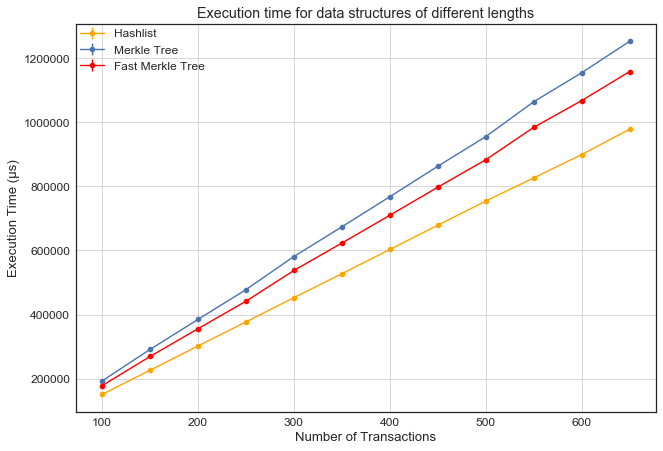

In [438]:
# build plot
plt.errorbar(lenghts, hl_build_m_means, yerr=hl_build_m_stds, marker='o', color='orange', label='Hashlist')
plt.errorbar(lenghts, mt_build_m_means, yerr=mt_build_m_stds, marker='o', label='Merkle Tree')
plt.errorbar(lenghts, fmt_build_m_means, yerr=fmt_build_m_stds, marker='o', color='red', label='Fast Merkle Tree')
plt.title('Execution time for data structures of different lengths')
plt.grid(True)
plt.xlabel('Number of Transactions')
plt.ylabel('Execution Time (µs)')
plt.legend(bbox_to_anchor=(0, 1), loc=2, borderaxespad=0.)
print('Done!')

Done!


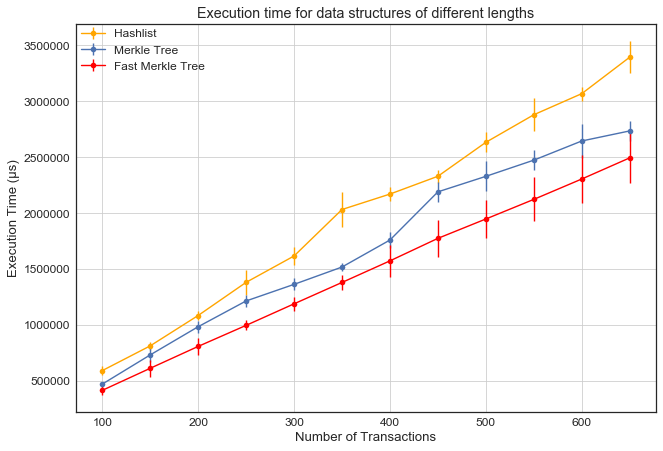

In [439]:
# build plot
plt.errorbar(lenghts, hl_veri_t_means, yerr=hl_veri_t_stds, marker='o', color='orange', label='Hashlist')
plt.errorbar(lenghts, mt_veri_t_means, yerr=mt_veri_t_stds, marker='o', label='Merkle Tree')
plt.errorbar(lenghts, fmt_veri_t_means, yerr=fmt_build_t_stds, marker='o', color='red', label='Fast Merkle Tree')
plt.title('Execution time for data structures of different lengths')
plt.grid(True)
plt.xlabel('Number of Transactions')
plt.ylabel('Execution Time (µs)')
plt.legend(bbox_to_anchor=(0, 1), loc=2, borderaxespad=0.)
print('Done!')

In [ ]:
# build plot
plt.errorbar(lenghts, hl_veri_t_means, yerr=hl_veri_t_stds, marker='o', color='orange', label='Hashlist')
plt.errorbar(lenghts, mt_veri_t_means, yerr=mt_veri_t_stds, marker='o', label='Merkle Tree')
plt.errorbar(lenghts, fmt_veri_t_means, yerr=fmt_build_t_stds, marker='o', color='red', label='Fast Merkle Tree')
plt.title('Execution time for data structures of different lengths')
plt.grid(True)
plt.xlabel('Number of Transactions')
plt.ylabel('Execution Time (µs)')
plt.legend(bbox_to_anchor=(0, 1), loc=2, borderaxespad=0.)
print('Done!')